# VAE Loading and Testing
In this notebook we load the trained VAE and test it's performance.

### Load the VAE


In [1]:
import os
import sys

# Get current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

# Add parent directory to Python path
parent_dir = os.path.dirname(cwd)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

Current working directory: /Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/my-experiments


In [2]:
import torch
from torchvision import datasets, transforms
import pickle as pickle
from src.utils import evaluate_vae

In [3]:
%matplotlib inline
import torch
from torchvision import datasets, transforms
from VAE.MNISTconv_bern import MNISTconv_VAE_bern_net
from VAE.train import train_VAE
from VAE.models import MNIST_generator_resnet, MNIST_recognition_resnet

save_dir = '../notebooks/saves'
new_save_dir = '../my-saves'


latent_dim = 20

batch_size = 64
nb_epochs = 300
lr = 7e-4
early_stop = 60

encoder = MNIST_recognition_resnet(latent_dim)
decoder = MNIST_generator_resnet(latent_dim)

# Determine device to use
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

VAE = MNISTconv_VAE_bern_net(latent_dim, encoder, decoder, lr, device=device)
VAE.new_load(new_save_dir+'/VAE_20d_MNIST.pt')


Net:
VAE_bern_net
    Total params: 1.33M
Reading ../my-saves/VAE_20d_MNIST.pt

Loading model to device: mps
  Restored epoch: 140, lr: 0.0007


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/src/utils.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, m

140

### Generate a few examples from the VAE


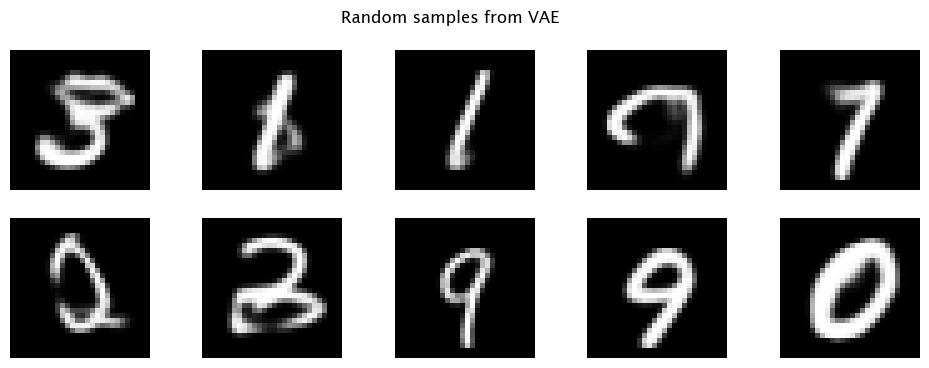

In [4]:
# Generate some random samples from the prior
z_sample = torch.randn(10, latent_dim, device=VAE.device)  # Create tensor on correct device

# Generate images from the random latent vectors
with torch.no_grad():
    x_rec = VAE.model.decode(z_sample)
    x_rec = torch.sigmoid(x_rec) # Apply sigmoid since using bernoulli VAE

# Plot the generated images
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    # Move tensor to CPU before plotting
    plt.imshow(x_rec[i].detach().cpu().reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle('Random samples from VAE')
plt.show()


### Load the data

In [5]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

batch_size = 1024

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=VAE.device.type == 'cuda', num_workers=3)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=VAE.device.type == 'cuda', num_workers=3)

## Test the VAE 


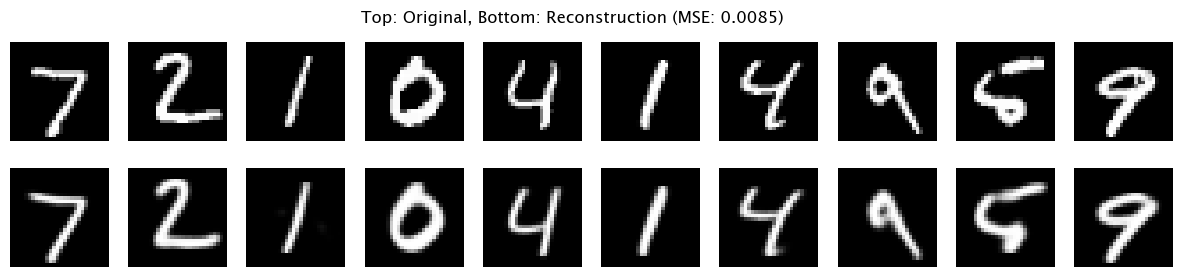

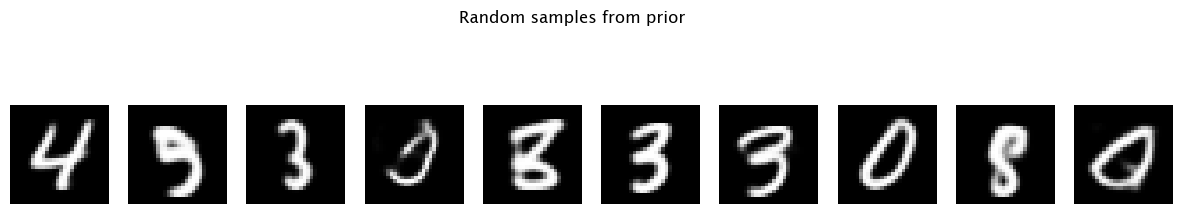

Test set VLB: -93.0382


In [6]:
# Evaluate the VAE using helper function
results = evaluate_vae(VAE, valloader, device=VAE.device, num_samples=10)

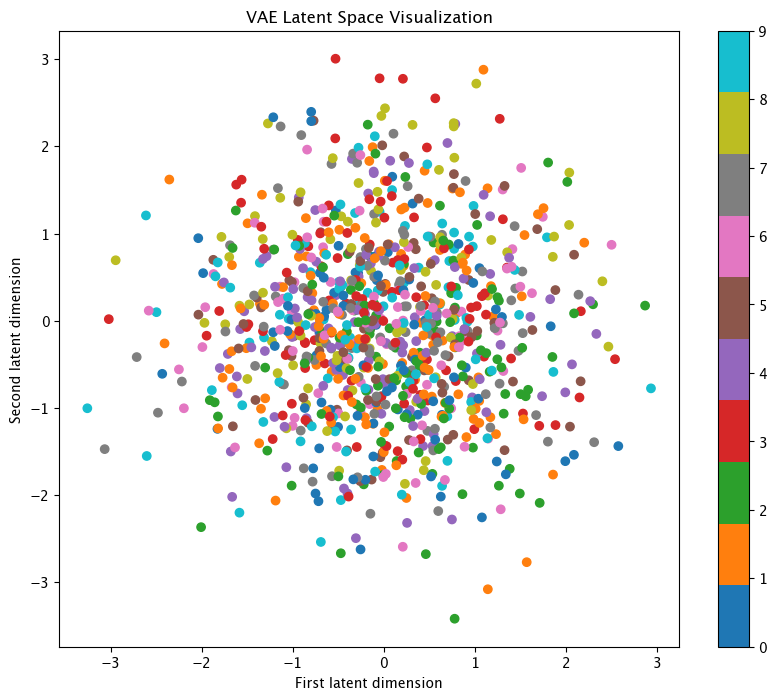

In [8]:
# Get a batch of test data
import numpy as np

dataiter = iter(valloader)
images, labels = next(dataiter)
images = images.to(VAE.device)

# Encode images to get latent representations
with torch.no_grad():
    # Use recongnition instead of encode
    approx_post = VAE.recongnition(images)
    # The approx_post is already a Normal distribution, we can sample from it directly
    z = approx_post.sample()

# Convert to 2D numpy arrays for plotting
z_np = z.cpu().numpy()
labels_np = labels.numpy()

# Create scatter plot of latent space
plt.figure(figsize=(10,8))
scatter = plt.scatter(z_np[:, 0], z_np[:, 1], c=labels_np, cmap='tab10')
plt.colorbar(scatter)
plt.xlabel('First latent dimension')
plt.ylabel('Second latent dimension')
plt.title('VAE Latent Space Visualization')
plt.show()

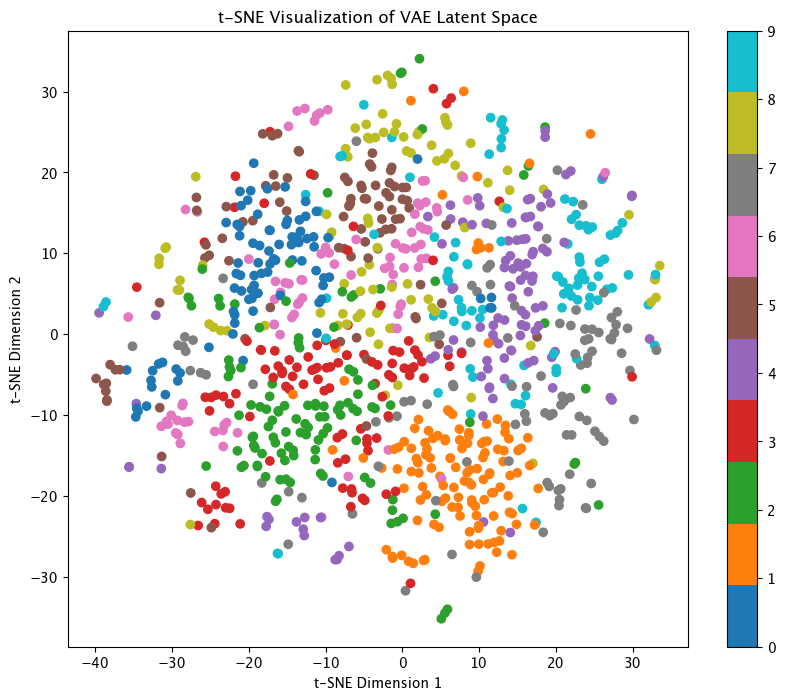

In [9]:
from sklearn.manifold import TSNE

# Flatten the latent space to 2D using t-SNE
z_flat = z.cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_flat)

# Plot the t-SNE result
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels_np, cmap='tab10')
plt.colorbar(scatter)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization of VAE Latent Space')
plt.show()

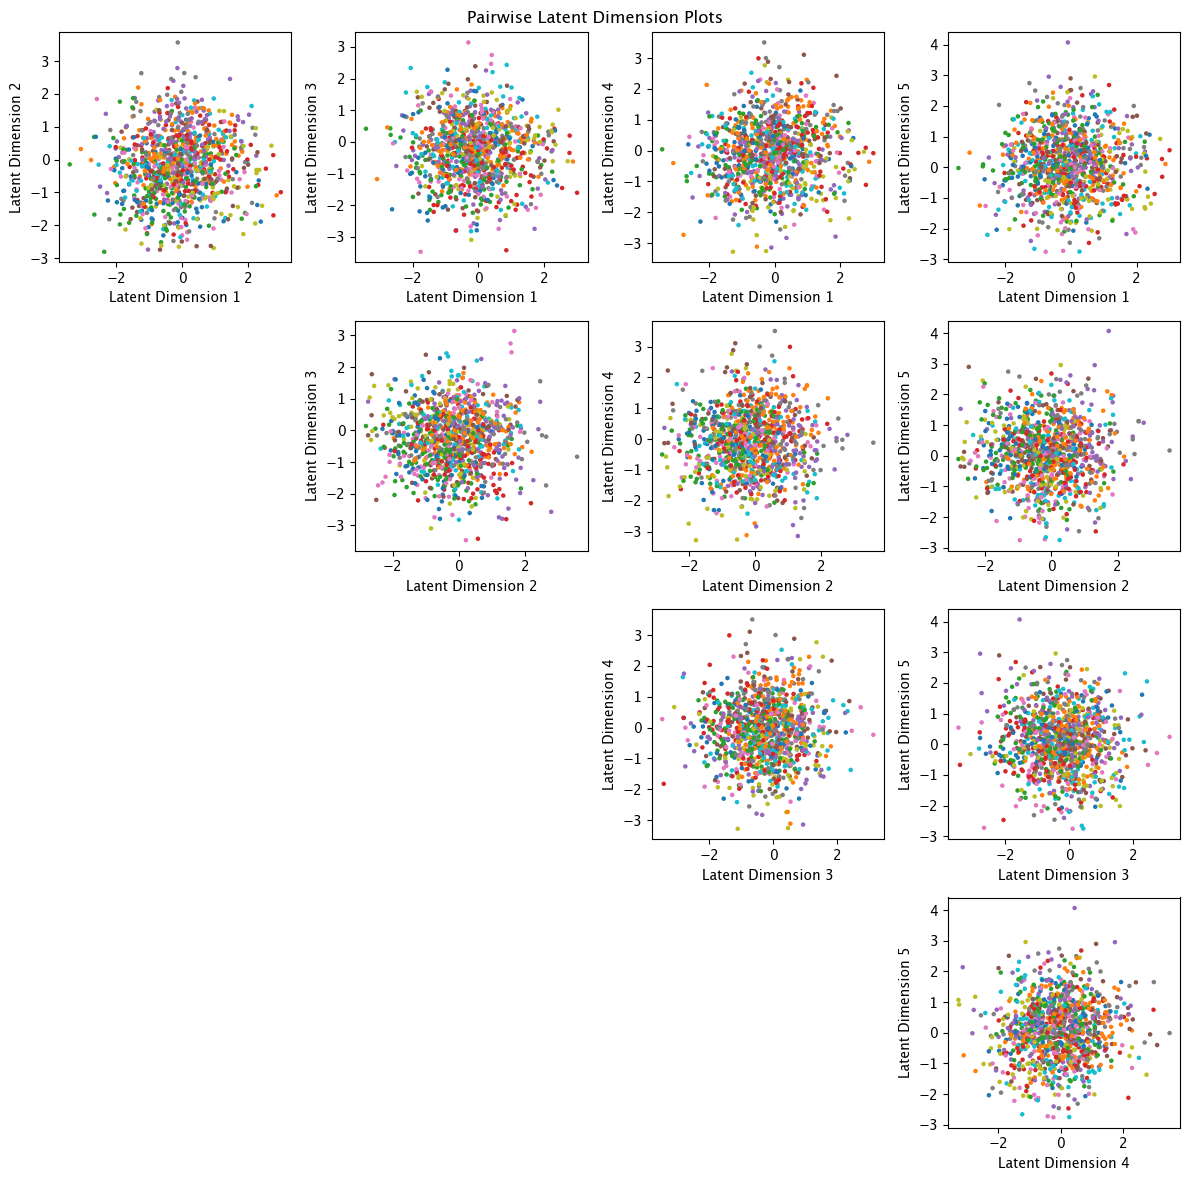

In [11]:
# Plot pairwise scatter plots for the first few dimensions
plt.figure(figsize=(12, 12))
for i in range(1, 5):
    for j in range(i+1, 6):
        plt.subplot(4, 4, (i-1)*4 + j-1)
        plt.scatter(z_np[:, i], z_np[:, j], c=labels_np, cmap='tab10', s=5)
        plt.xlabel(f'Latent Dimension {i}')
        plt.ylabel(f'Latent Dimension {j}')
plt.suptitle('Pairwise Latent Dimension Plots')
plt.tight_layout()
plt.show()